In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from numba import jit
from matplotlib import pyplot as plt
import time
from datetime import timedelta
import pandas as pd
from collections import OrderedDict
from itertools import cycle
from typing import Optional, Tuple
from transformers import AutoTokenizer
from sentencepiece import SentencePieceProcessor
from datasets import load_dataset

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device_cap = torch.cuda.get_device_capability()
device_type = "cuda" if "cuda" in device else "cpu"
torch.cuda.set_device(device)
torch.manual_seed(8855)
print(torch.__version__)
print(device, device_cap)

### Llama 3 from Scratch

In [ ]:
# Using Huggingface
tokenizer = AutoTokenizer.from_pretrained("./llama3/")
#tokenizer.add_special_tokens({"pad_token": "<PAD>"})
tokenizer.pad_token = tokenizer.eos_token #Optional

vocab = tokenizer.vocab

In [ ]:
def encode(example):
    return tokenizer.encode(example, return_tensors="pt")


def decode(example):
    return tokenizer.batch_decode(
        example,
        skip_special_tokens=False,
        clean_up_tokenization_spaces=True,
    )[0]


print(f"Vocab Size: {len(vocab)}")
decode(
    encode(
        "hello I am a specifically designed long sentence to make sure this is working not only adequately, but good enough for our batch functions"
    )
)

In [ ]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
    "batch_size": 16,
    "context_window": 32,
    "d_model": 288,
    "epochs": 1000,
    "hidden_dim": 768,
    "log_interval": 50,
    "n_heads": 6,
    "n_layers": 6,
}

GLOBAL_KEEP_TRACK = []

In [ ]:
# Local Data only
dataset = load_dataset(
    "text",
    data_files={
        "train": ["../../data/CombinedTinyStories-train.txt"],
        "val": ["../../data/CombinedTinyStories-valid.txt"],
    },
    streaming=True,
)

# Stream Data
# dataset = load_dataset('IMJONEZZ/CombinedTinyStories') # optional: streaming=True but to_iterable is faster
# dataset = dataset.to_iterable_dataset()

# Minimal preprocessing
clean_dataset = dataset.filter(lambda example: len(example["text"]) > 2)

In [ ]:
prompt = "Write a short story. Possible Story: "
tokenized_prompt = tokenizer(prompt, return_tensors="pt").input_ids

encoded_dataset = clean_dataset.map(
    lambda examples: tokenizer(
        [prompt + x for x in examples["text"]],
        padding=True,
        return_tensors="pt",
    ),
    batched=True,
)
train_data = iter(encoded_dataset["train"].shuffle())
val_data = iter(encoded_dataset["val"].shuffle())
train_data = cycle(train_data)
val_data = cycle(val_data)

test = next(train_data)
print(f"Actual text: {test['text']}")
print(f"Input Ids: {tokenizer.decode(test['input_ids'])}")
print(f"Length of text: {len(test['input_ids'])}")
print(test)

### Needed functions

In [ ]:
# @torch.compile #For non-Windows users
def get_batches(
    data,
    batch_size,
    context_window,
    config=MASTER_CONFIG,
    debug=False,
):
    x = []
    y = []
    for _ in range(
        batch_size
    ):  # Adjust this lower if you're running out of memory
        batch_data = next(data)

        # pick random starting points
        ix = torch.randint(
            0, len(batch_data["input_ids"]) - context_window - 1, (2,)
        )
        batch_x = torch.stack(
            [batch_data["input_ids"][i : i + context_window] for i in ix]
        ).long()
        batch_y = torch.stack(
            [
                batch_data["input_ids"][i + 1 : i + context_window + 1]
                for i in ix
            ]
        ).long()
        x.append(batch_x)
        y.append(batch_y)
    x = torch.cat((x), 0).to(device)
    y = torch.cat((y), 0).to(device)
    if debug:
        print(f"ix: {ix}\nx: {x}\ny: {y}")
    return x, y


def get_lora_batches(
    data,
    batch_size,
    context_window=32,
):
    x = []
    y = []
    for _ in range(batch_size // 2):
        x_data = next(data)
        y_data = next(data)

        x_data = torch.stack([x_data["input_ids"]]).long()
        y_data = torch.stack([y_data["input_ids"]]).long()

        x.append(x_data)
        y.append(y_data)
    x = torch.cat((x), 0).to(device)
    y = torch.cat((y), 0).to(device)
    return x, y

xs, ys = get_batches(
                    train_data, 16, 32
                )
print(xs)
print(ys)

In [ ]:
@torch.no_grad()
def get_loss(model, lora=False, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for name, split in zip(["train", "val"], [train_data, val_data]):
        losses = []
        for _ in range(10):
            if lora == True:
                xb, yb = get_lora_batches(
                    split, config["batch_size"], config["context_window"]
                )
            else:
                xb, yb = get_batches(
                    split,
                    config["batch_size"],
                    config["context_window"],
                )
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[name] = np.mean(losses)
    model.train()
    return out


@torch.inference_mode()
def generate(
    model,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=None,
    max_new_tokens=30,
    lora=False,
):
    idx_list = [tokenized_prompt] * 5
    idx = torch.cat((idx_list), 0).long().to(device)
    if lora:
        idx = (
            torch.ones(5, 1).long().to(device)
        )  # Alternative without prompt
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config["context_window"] :])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits

        last_time_step_logits = last_time_step_logits / temperature
        if top_k is not None:
            v, _ = torch.topk(
                last_time_step_logits,
                min(top_k, last_time_step_logits.size(-1)),
            )
            last_time_step_logits[last_time_step_logits < v[:, [-1]]] = (
                -float("Inf")
            )
        p = F.softmax(
            last_time_step_logits, dim=-1
        )  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [tokenizer.decode(x) for x in idx.tolist()]

### Two-layer Feed Forward Network

In [ ]:
class SimpleFeedForwardNN(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN(MASTER_CONFIG).to(device)
# opt_model = torch.compile(model) #Again, non-Windows folks should be compiling functions and models
# xs, ys = get_batches(
#     train_data,
#     MASTER_CONFIG["batch_size"],
#     MASTER_CONFIG["context_window"],
# )

# logits, loss = model(xs, ys)

### Training Loop

In [ ]:
def train(
    model,
    optimizer,
    scheduler=None,
    data=None,
    config=MASTER_CONFIG,
    lora=False,
    print_logs=False,
):
    losses = []
    start_time = time.time()
    for epoch in range(config["epochs"]):
        try:
            optimizer.zero_grad()

            if lora:
                xs, ys = get_lora_batches(data, config["batch_size"])
            else:
                xs, ys = get_batches(
                    data, config["batch_size"], config["context_window"]
                )

            # #If you really want to overfit
            # for i in range(1, config["context_window"] + 1):
            #     x = xs[:i]
            #     y = ys[:i]
            #     logits, loss = model(x, targets=y)
            #     loss.backward()
            #     optimizer.step()

            logits, loss = model(xs, targets=ys)
            loss.backward()
            optimizer.step()

            if scheduler:
                scheduler.step()

            if epoch % config["log_interval"] == 0:
                batch_time = time.time() - start_time
                x = get_loss(model, lora=lora)
                losses += [x]
                if print_logs:
                    print(
                        f"Epoch {epoch} | train loss {x['train']:.3f} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA: {timedelta(seconds=(batch_time * (config['epochs'] - epoch)/config['log_interval']))}"
                    )
                start_time = time.time()

                if scheduler:
                    print("lr: ", scheduler.get_last_lr())
        except StopIteration:
            print(f"Reached end of dataset on step {epoch}")
            break

    GLOBAL_KEEP_TRACK.append(
        f"{type(model).__name__} {sum([m.numel() for m in model.parameters()])} Params | Train: {losses[-1]['train']:.3f} | Val: {losses[-1]['val']:.3f}"
    )
    print(
        f"training loss {losses[-1]['train']:.3f} | validation loss: {losses[-1]['val']:.3f}"
    )
    return pd.DataFrame(losses).plot(xlabel="Step // 50", ylabel="Loss")

In [ ]:
optimizer = torch.optim.AdamW(
    model.parameters(),
)
train(model, optimizer, data=train_data, print_logs=True)

In [ ]:
generate(model, config=MASTER_CONFIG)

In [ ]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

### RMS Normalization

In [ ]:
class RMSNormalization(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.register_parameter(
            "scale", nn.Parameter(torch.ones(dim))
        )

    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return output * self.scale[: x.shape[1], :].unsqueeze(0)

In [ ]:
class SimpleFeedForwardNN_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization((config["d_model"], config["d_model"]))
        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            nn.ReLU(),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)  # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [ ]:
generate(model, config=MASTER_CONFIG)

In [ ]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

### RoPE scaling

In [ ]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros(
        (context_window, embedding_dim, embedding_dim), requires_grad=False
    )
    for position in range(context_window):
        for i in range(embedding_dim // 2):
            theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2 * i, 2 * i] = np.cos(m_theta)
            R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
            R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
    return R

In [ ]:
from IPython.display import clear_output

K = 3
config = {
    "batch_size": 10,
    "d_model": 32,
    "n_heads": 8,
    "context_window": K**2,
}
batch = torch.randn(1, config["context_window"], config["d_model"])
R = get_rotary_matrix(config["context_window"], config["d_model"])
# clear_output()
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f"rotation at {i * K + j}")

In [ ]:
config = {
    "batch_size": 10,
    "d_model": 512,
    "n_heads": 8,
    "context_window": 16,
}


class RoPEMaskedAttentionHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_k = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )
        self.w_v = nn.Linear(
            config["d_model"], config["d_model"], bias=False
        )

        self.R = get_rotary_matrix(
            config["context_window"], config["d_model"]
        ).to(device)

    @jit(nopython=False)
    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros(
            (context_window, embedding_dim, embedding_dim),
            requires_grad=False,
        )
        for position in range(context_window):
            for i in range(embedding_dim // 2):
                theta = 10000.0 ** (-2.0 * (i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2 * i, 2 * i] = np.cos(m_theta)
                R[position, 2 * i, 2 * i + 1] = -np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i] = np.sin(m_theta)
                R[position, 2 * i + 1, 2 * i + 1] = np.cos(m_theta)
        return R

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape

        q = self.w_q(x).to(device)
        k = self.w_k(x).to(device)
        v = self.w_v(x).to(device)

        q_rotated = (
            (torch.bmm(q.transpose(0, 1), self.R[:m]))
            .transpose(0, 1)
            .to(device)
        )
        k_rotated = (
            (torch.bmm(k.transpose(0, 1), self.R[:m]))
            .transpose(0, 1)
            .to(device)
        )

        activations = F.scaled_dot_product_attention(
            q_rotated, k_rotated, v, dropout_p=0.1, is_causal=True
        )

        if return_attn_weights:
            attn_mask = torch.tril(torch.ones((m, m)), diagonal=0).to(
                device
            )
            attn_weights = (
                torch.bmm(q_rotated, k_rotated.transpose(1, 2)) / np.sqrt(d)
                + attn_mask
            )
            attn_weights = F.softmax(attn_weights, dim=-1)
            return activations, attn_weights
        return activations


layer = RoPEMaskedAttentionHead(config)
batch = torch.randn(
    (config["batch_size"], config["context_window"], config["d_model"])
)
output, attn_weights = layer(batch, return_attn_weights=True)

In [ ]:
class RoPEMaskedMultiheadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList(
            [
                RoPEMaskedAttentionHead(config).to(device)
                for _ in range(config["n_heads"])
            ]
        )
        self.linear = nn.Linear(
            config["n_heads"] * config["d_model"], config["d_model"]
        ).to(device)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = x.to(device)
        heads = [h(x) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x


layer = RoPEMaskedMultiheadAttention(MASTER_CONFIG)
batch = torch.ones(
    (
        MASTER_CONFIG["batch_size"],
        MASTER_CONFIG["context_window"],
        MASTER_CONFIG["d_model"],
    )
)
output = layer(batch)
output.shape

Epoch 550 | train loss 4.033 | val loss 4.156 | Time 1.628 | ETA: 0:00:14.651062
Epoch 600 | train loss 4.201 | val loss 4.256 | Time 1.618 | ETA: 0:00:12.944433
Epoch 650 | train loss 4.230 | val loss 4.344 | Time 1.612 | ETA: 0:00:11.284075
Epoch 700 | train loss 4.546 | val loss 4.112 | Time 1.603 | ETA: 0:00:09.618363
Epoch 750 | train loss 4.473 | val loss 4.514 | Time 1.611 | ETA: 0:00:08.057482
Epoch 800 | train loss 4.590 | val loss 4.129 | Time 1.786 | ETA: 0:00:07.143560
Epoch 850 | train loss 4.447 | val loss 4.660 | Time 1.646 | ETA: 0:00:04.936961
Epoch 900 | train loss 4.340 | val loss 4.492 | Time 1.635 | ETA: 0:00:03.270883
Epoch 950 | train loss 4.122 | val loss 4.216 | Time 1.662 | ETA: 0:00:01.661775
training loss 4.122 | validation loss: 4.216


<Axes: xlabel='Step // 50', ylabel='Loss'>

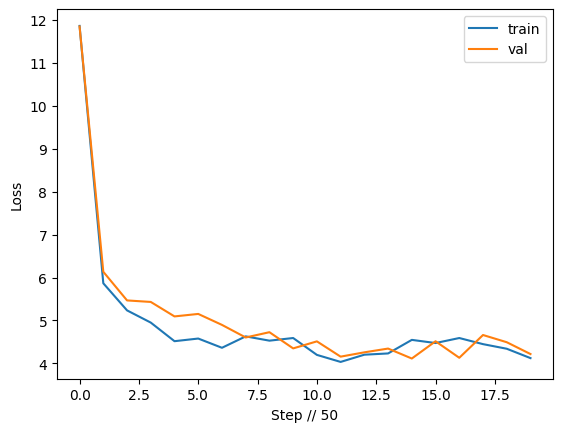

In [22]:
class SimpleFeedForwardNN_RMS_Rope(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization(
            (config["d_model"], config["d_model"])
        ).to(device)
        self.rope_attention = RoPEMaskedMultiheadAttention(config).to(
            device
        )

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]), nn.ReLU()
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_Rope(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [23]:
generate(model, config=MASTER_CONFIG)

['<|begin_of_text|>Write a short story. Possible Story: 3 him. She was holding the bear she could bounce around theulu\'s go to his things, and I can talk it couldn and!" wanted to',
 "<|begin_of_text|>Write a short story. Possible Story: 3 years old she didn't today. She felt much better held and her toys. She stopped to do something new toys. One day, Lily was",
 '<|begin_of_text|>Write a short story. Possible Story: 3 year old owl comes to be cute had to have a to be scared after to help his next time and my walk. She trust it or her',
 '<|begin_of_text|>Write a short story. Possible Story:  smiled and said, "It\'s everything for special wish!":, "What\'s family in and Joe!" the little mouse crashed, and smooth.',
 "<|begin_of_text|>Write a short story. Possible Story:  Everyday playing, he opened it's play book close like it for. It was a little man who lived in a lock to play but out. He"]

In [24]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 74086944 Params | Train: 4.189 | Val: 4.471
SimpleFeedForwardNN_RMS 74169888 Params | Train: 4.260 | Val: 4.492
SimpleFeedForwardNN_RMS_Rope 76160832 Params | Train: 4.122 | Val: 4.216


### SwiGLU

In [25]:
class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(
            self.beta * self.linear_gate(x)
        )
        out = swish_gate * self.linear(x)
        return out

model params: 76327297
Epoch 0 | train loss 11.859 | val loss 11.882 | Time 0.031 | ETA: 0:00:00.617962
Epoch 50 | train loss 5.699 | val loss 6.227 | Time 1.680 | ETA: 0:00:31.921274
Epoch 100 | train loss 5.289 | val loss 5.644 | Time 1.674 | ETA: 0:00:30.139287
Epoch 150 | train loss 4.962 | val loss 5.546 | Time 1.660 | ETA: 0:00:28.219410
Epoch 200 | train loss 4.744 | val loss 5.243 | Time 1.677 | ETA: 0:00:26.839001
Epoch 250 | train loss 5.080 | val loss 4.997 | Time 1.690 | ETA: 0:00:25.342544
Epoch 300 | train loss 4.470 | val loss 4.632 | Time 1.703 | ETA: 0:00:23.841747
Epoch 350 | train loss 4.329 | val loss 4.634 | Time 1.722 | ETA: 0:00:22.391763
Epoch 400 | train loss 4.603 | val loss 4.613 | Time 1.698 | ETA: 0:00:20.371745
Epoch 450 | train loss 4.599 | val loss 4.752 | Time 1.670 | ETA: 0:00:18.371150
Epoch 500 | train loss 4.025 | val loss 4.523 | Time 1.672 | ETA: 0:00:16.721938
Epoch 550 | train loss 4.347 | val loss 4.394 | Time 1.688 | ETA: 0:00:15.188408
Epoch 

<Axes: xlabel='Step // 50', ylabel='Loss'>

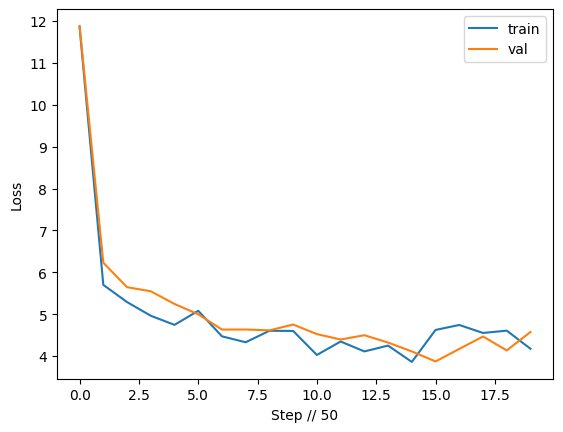

In [26]:
class SimpleFeedForwardNN_RMS_RoPE_SwiGLU(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.rms = RMSNormalization((config["d_model"], config["d_model"]))
        self.rope_attention = RoPEMaskedMultiheadAttention(config)

        self.linear = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
        )

        self.last_linear = nn.Linear(
            config["d_model"], config["vocab_size"]
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

        else:
            return logits


model = SimpleFeedForwardNN_RMS_RoPE_SwiGLU(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters())
train(model, optimizer, data=train_data, print_logs=True)

In [27]:
generate(model, config=MASTER_CONFIG)

['<|begin_of_text|>Write a short story. Possible Story:  stand. Possible Story: One sunny day, the family kept enjoying and Haus and laughed That has her playing with his family to play balancing. That mom',
 "<|begin_of_text|>Write a short story. Possible Story:  say the board. They both licked the cro and didn't the ink the girl. She was sad and saw a cool. The boy whispered. She",
 '<|begin_of_text|>Write a short story. Possible Story:  Billy was still snacks grabbed McN rabbit very muchmy was too! The girl was so happy and suddenly loved watching happy. He smiled. One day,',
 '<|begin_of_text|>Write a short story. Possible Story:  Ben too. They saw the ice cream and saw some cookies. They had treasure fell by the village absolutely crying, but it was so excited to try',
 '<|begin_of_text|>Write a short story. Possible Story:  mommy and Mil "Yes there." She hope or something. Tom wasabel. He crawl, he could show the· of the home.  and']

In [28]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 74086944 Params | Train: 4.189 | Val: 4.471
SimpleFeedForwardNN_RMS 74169888 Params | Train: 4.260 | Val: 4.492
SimpleFeedForwardNN_RMS_Rope 76160832 Params | Train: 4.122 | Val: 4.216
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 76327297 Params | Train: 4.174 | Val: 4.575


In [29]:
del model
with torch.no_grad():
    torch.cuda.empty_cache()
import gc

gc.collect()

71

### Llama

In [30]:
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNormalization(
            (config["d_model"], config["d_model"])
        )

        self.attention = RoPEMaskedMultiheadAttention(config).to(device)
        self.feedforward = nn.Sequential(
            nn.Linear(config["d_model"], config["hidden_dim"]),
            SwiGLU(config["hidden_dim"]),
            nn.Linear(config["hidden_dim"], config["d_model"]),
        )

    def forward(self, x):
        h = x + self.attention(self.rms(x))
        out = h + self.feedforward(self.rms(x))
        return out

In [31]:
class SimpleLlama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(
            config["vocab_size"], config["d_model"]
        )
        self.llama_blocks = nn.Sequential(
            OrderedDict(
                [
                    (f"llama_{i}", LlamaBlock(config).to(device))
                    for i in range(config["n_layers"])
                ]
            )
        )

        self.ffn = nn.Sequential(
            nn.Linear(config["d_model"], config["d_model"]),
            SwiGLU(config["d_model"]),
            nn.Linear(config["d_model"], config["vocab_size"]),
        )

        print(
            f"model params: {sum([m.numel() for m in self.parameters()])}"
        )

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits

        else:
            loss = F.cross_entropy(
                logits.view(-1, self.config["vocab_size"]),
                targets.view(-1),
                ignore_index=tokenizer.pad_token_id,
                # reduction="sum",
            )
            return logits, loss

model params: 96444391
Epoch 0 | train loss 11.728 | val loss 11.725 | Time 0.244 | ETA: 0:00:04.887486
Epoch 50 | train loss 6.848 | val loss 6.659 | Time 3.357 | ETA: 0:01:03.783976
Epoch 100 | train loss 5.969 | val loss 5.776 | Time 3.369 | ETA: 0:01:00.640025
Epoch 150 | train loss 5.351 | val loss 5.842 | Time 3.347 | ETA: 0:00:56.907477
Epoch 200 | train loss 5.066 | val loss 5.724 | Time 3.308 | ETA: 0:00:52.926136
Epoch 250 | train loss 4.996 | val loss 5.338 | Time 3.333 | ETA: 0:00:50.001283
Epoch 300 | train loss 5.972 | val loss 6.369 | Time 3.352 | ETA: 0:00:46.923183
Epoch 350 | train loss 11.583 | val loss 11.590 | Time 3.375 | ETA: 0:00:43.878220
Epoch 400 | train loss 259916.003 | val loss 291686.789 | Time 3.398 | ETA: 0:00:40.771173
Epoch 450 | train loss 11.360 | val loss 11.366 | Time 3.391 | ETA: 0:00:37.302152
Epoch 500 | train loss 11.254 | val loss 11.264 | Time 3.356 | ETA: 0:00:33.560960
Epoch 550 | train loss 11.166 | val loss 11.164 | Time 3.378 | ETA: 0:0

<Axes: xlabel='Step // 50', ylabel='Loss'>

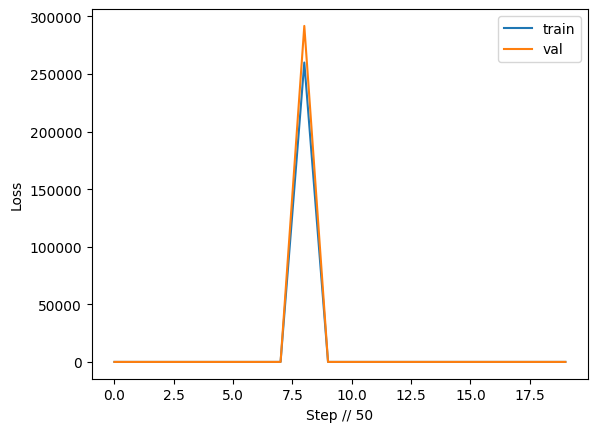

In [32]:
llama = SimpleLlama(MASTER_CONFIG).to(device)
optimizer = torch.optim.AdamW(llama.parameters())
train(
    llama, optimizer, data=train_data, config=MASTER_CONFIG, print_logs=True
)

This is why you need a scheduler lol

In [33]:
generate(
    llama,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=25,
    max_new_tokens=50,
)

['<|begin_of_text|>Write a short story. Possible Story:  The happy happy her: the. her she on, Tim she Lily. that was day " she, but to it story the on, Lily and, and a Tim happy,. but said said said a she for happy it on that " and',
 '<|begin_of_text|>Write a short story. Possible Story:, for to was she the her happy a but., the it but in on was story she The " it The was she: story day " she story, the said Lily: The Story:. in in. but her day for was for',
 '<|begin_of_text|>Write a short story. Possible Story:  " Story but a it: The Tim the: Lily said. Tim Lily it said, Lily the said in Story said day Story she to on and that said for. that and, on that to it Story. on was Tim she happy that Story',
 '<|begin_of_text|>Write a short story. Possible Story: : in Lily but a day that a,: and story, Story day day and for on in on. story day Tim Lily was she was the a that a to the and: she, her day happy happy to a day that: to for',
 '<|begin_of_text|>Write a short story. Possible Stor

In [34]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 74086944 Params | Train: 4.189 | Val: 4.471
SimpleFeedForwardNN_RMS 74169888 Params | Train: 4.260 | Val: 4.492
SimpleFeedForwardNN_RMS_Rope 76160832 Params | Train: 4.122 | Val: 4.216
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 76327297 Params | Train: 4.174 | Val: 4.575
SimpleLlama 96444391 Params | Train: 10.516 | Val: 10.530


In [35]:
#MASTER_CONFIG['epochs'] = 52171228 // MASTER_CONFIG['batch_size'] # If you want to do a full epoch
MASTER_CONFIG['epochs'] = 1000
MASTER_CONFIG["batch_size"] = 16
MASTER_CONFIG["d_model"] = 768
MASTER_CONFIG["n_layers"] = 8
MASTER_CONFIG["context_window"] = 64

llama = SimpleLlama(MASTER_CONFIG).to(device)

llama_optimizer = torch.optim.AdamW(
    llama.parameters(),
    betas=(0.9, 0.95),
    weight_decay=1e-1,
    eps=1e-9,
    lr=5e-4,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    llama_optimizer, 1000, eta_min=1e-5
)

model params: 335771145


Epoch 0 | train loss 11.709 | val loss 11.684 | Time 0.313 | ETA: 0:00:06.267281
lr:  [0.0004999987909744553]
Epoch 50 | train loss 6.900 | val loss 7.298 | Time 16.386 | ETA: 0:05:11.327543
lr:  [0.0004968620434287298]
Epoch 100 | train loss 5.657 | val loss 5.853 | Time 16.346 | ETA: 0:04:54.230445
lr:  [0.00048776984967968684]
Epoch 150 | train loss 5.619 | val loss 5.597 | Time 16.363 | ETA: 0:04:38.168279
lr:  [0.0004729460897126908]
Epoch 200 | train loss 5.305 | val loss 5.427 | Time 16.374 | ETA: 0:04:21.982731
lr:  [0.0004527557736953662]
Epoch 250 | train loss 5.687 | val loss 6.308 | Time 16.404 | ETA: 0:04:06.059110
lr:  [0.0004276960542158767]
Epoch 300 | train loss 4.920 | val loss 5.247 | Time 16.341 | ETA: 0:03:48.774972
lr:  [0.00039838398473624826]
Epoch 350 | train loss 5.209 | val loss 5.015 | Time 16.249 | ETA: 0:03:31.236198
lr:  [0.00036554132568825045]
Epoch 400 | train loss 4.734 | val loss 5.247 | Time 16.323 | ETA: 0:03:15.880179
lr:  [0.0003299767723361813]


<Axes: xlabel='Step // 50', ylabel='Loss'>

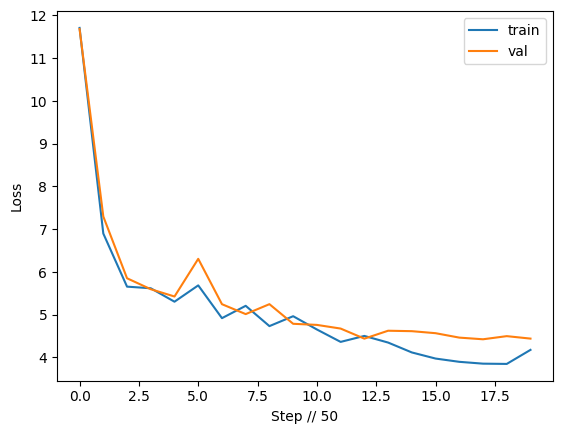

In [36]:
train(
    llama,
    llama_optimizer,
    scheduler=scheduler,
    data=train_data,
    config=MASTER_CONFIG,
    print_logs=True,
)

In [37]:
generate(
    llama,
    config=MASTER_CONFIG,
    temperature=1.0,
    top_k=5,
    max_new_tokens=50,
)

['<|begin_of_text|>Write a short story. Possible Story:  mom said, "I have to play with my friend, but we are not a great friend." She says, "It is very happy. It is a big and a big box. He is a good day. It is a big smile and',
 '<|begin_of_text|>Write a short story. Possible Story:  mom asked him to the dog. The end and said, "It is not happy!" Lily asks. She had many fun of her mom, and the dog were happy. She was very happy to go to the water, and the bird was sad',
 '<|begin_of_text|>Write a short story. Possible Story:  mom asked the park and they were playing with the ball. It wanted to be careful with a big tree. It was a big box in the park and ran to her. They went to the park and put on it in the park. They had',
 '<|begin_of_text|>Write a short story. Possible Story:  mom says that she was very proud of the dog. She was very sad. She had a small box in the sky. She had to see what it was. She said, "Thank you, mom." Tim and they could not a lot of',
 '<|begin_of_text|>Write

In [38]:
for i in GLOBAL_KEEP_TRACK:
    print(i)

SimpleFeedForwardNN 74086944 Params | Train: 4.189 | Val: 4.471
SimpleFeedForwardNN_RMS 74169888 Params | Train: 4.260 | Val: 4.492
SimpleFeedForwardNN_RMS_Rope 76160832 Params | Train: 4.122 | Val: 4.216
SimpleFeedForwardNN_RMS_RoPE_SwiGLU 76327297 Params | Train: 4.174 | Val: 4.575
SimpleLlama 96444391 Params | Train: 10.516 | Val: 10.530
SimpleLlama 335771145 Params | Train: 4.178 | Val: 4.442


# Quantization

In [39]:
llama.to("cpu")
qconfig_dict = {
    torch.nn.Embedding: torch.quantization.float_qparams_weight_only_qconfig,
    torch.nn.Linear: torch.quantization.default_dynamic_qconfig,
}
# Post Training Dynamic Quantization
dynamic_quantized_llama = torch.quantization.quantize_dynamic(
    llama, qconfig_dict, dtype=torch.qint8
)


# Get Size difference
def get_param_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    return param_size


def get_buffer_size(model):
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    return buffer_size


def get_param_and_buffer_size(model):
    param_size = get_param_size(model)
    buffer_size = get_buffer_size(model)
    return param_size, buffer_size


def get_size_difference(models: list) -> str:
    keeping_track = []
    for idx, model in enumerate(models):
        param_size, buffer_size = get_param_and_buffer_size(model)
        size_all_mb = (param_size + buffer_size) / 1024**2
        keeping_track.append(
            f"{type(model).__name__} size: {size_all_mb:.3f}MB"
        )
    return keeping_track


list_of_sizes = get_size_difference([llama, dynamic_quantized_llama])
for size in list_of_sizes:
    print(size)

SimpleLlama size: 1280.865MB
SimpleLlama size: 18.000MB


# LoRA

If you have this:

<p>def forward(self, x):<br>
    x = self.linear_1(x)<br>
    x = F.relu(x)<br>
    x = self.linear_2(x)<br>
    return x<br></p>

change it to this:

<p>def forward(self, x):<br>
    x = self.linear_1(x) + self.lora_1(x)<br>
    x = F.relu(x)<br>
    x = self.linear_2(x) + self.lora_2(x)<br>
    return logits<br></p>

In [40]:
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        standard_deviation = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(
            torch.randn(in_dim, rank) * standard_deviation
        )
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x


class LinearWithLoRA(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        return self.linear(x) + self.lora(x)

In [41]:
from functools import partial


# Utils
class LoRAParametrization(nn.Module):
    def __init__(
        self,
        fan_in,
        fan_out,
        fan_in_fan_out=False,
        rank=0,
        lora_dropout_p=0.0,
        lora_alpha=1,
    ):
        super().__init__()
        self.swap = (
            (lambda x: (x[1], x[0])) if fan_in_fan_out else (lambda x: x)
        )
        self.lora_A = nn.Parameter(torch.zeros(self.swap((rank, fan_in))))
        self.lora_B = nn.Parameter(torch.zeros(self.swap((fan_out, rank))))
        self.lora_alpha, self.rank = lora_alpha, rank
        self.scaling = lora_alpha / rank
        self.lora_dropout = (
            nn.Dropout(p=lora_dropout_p)
            if lora_dropout_p > 0
            else lambda x: x
        )
        self.dropout_fn = (
            self._dropout if lora_dropout_p > 0 else lambda x: x
        )
        self.register_buffer(
            "lora_dropout_mask",
            torch.ones(self.swap((1, fan_in)), dtype=self.lora_A.dtype),
        )
        self.forward_fn = self.lora_forward

    def forward(self, X):
        return self.forward_fn(X)

    def lora_forward(self, X):
        return (
            X
            + torch.matmul(
                *self.swap((self.lora_B, self.dropout_fn(self.lora_A)))
            ).view(X.shape)
            * self.scaling
        )

    @classmethod
    def lora_from_layer(
        cls, layer, rank=0, lora_dropout_p=0.0, lora_alpha=1
    ):
        fan_out, fan_in = layer.weight.shape
        return cls(
            fan_in,
            fan_out,
            fan_in_fan_out=False,
            rank=rank,
            lora_dropout_p=lora_dropout_p,
            lora_alpha=lora_alpha,
        )


lora_config = {
    nn.Linear: {
        "weight": partial(LoRAParametrization.lora_from_layer, rank=16),
    },
}


def apply_lora(layer, register=True, merge=False, lora_config=lora_config):
    if register:
        if type(layer) in lora_config:
            for attr_name, parametrization in lora_config[
                type(layer)
            ].items():
                torch.nn.utils.parametrize.register_parametrization(
                    layer, attr_name, parametrization(layer)
                )
    else:
        if hasattr(layer, "parametrizations"):
            for attr_name in layer.parametrizations.keys():
                torch.nn.utils.parametrize.remove_parametrizations(
                    layer, attr_name, leave_parametrized=merge
                )


def add_lora(model, lora_config=lora_config):
    model.apply(partial(apply_lora, lora_config=lora_config))


def remove_lora(model):
    """remove lora parametrization to all layers in a model. This will remove all parametrization"""
    model.apply(partial(apply_lora, register=False, merge=False))


def merge_lora(model):
    model.apply(partial(apply_lora, register=False, merge=True))


def name_is_lora(name):
    return (
        len(name.split(".")) >= 4
        and (name.split(".")[-4]) == "parametrizations"
        and name.split(".")[-1] in ["lora_A", "lora_B"]
    )


def get_params_by_name(model, print_shapes=False, name_filter=None):
    for n, p in model.named_parameters():
        if name_filter is None or name_filter(n):
            if print_shapes:
                print(n, p.shape)
            yield p


def get_lora_params(model, print_shapes=False):
    return get_params_by_name(
        model, print_shapes=print_shapes, name_filter=name_is_lora
    )

In [42]:
# New Dataset for Lora
dataset = load_dataset(
    "text",
    data_files={
        "train": ["../../data/Lima-train.csv"],
        "val": ["../../data/Lima-test.csv"],
    },
    streaming=True,
)

encoded_dataset = dataset.map(
    lambda examples: tokenizer(
        examples["text"],
        padding=True,
        max_length=MASTER_CONFIG["context_window"],
        truncation=True,
        return_tensors="pt",
    ),
    batched=True,
)
train_data = iter(encoded_dataset["train"].shuffle())
val_data = iter(encoded_dataset["val"].shuffle())
train_data = cycle(train_data)
val_data = cycle(val_data)

In [43]:
# Step 1: Add LoRA to trained model
llama.to("cpu")
add_lora(llama)
llama.to(device)

# Step 2: Get the LoRA params instead of the whole model's
parameters = [{"params": list(get_lora_params(llama))}]
# Step 3: initialize optimizer with LoRA Params
lora_optimizer = torch.optim.AdamW(parameters, lr=1e-3)

Epoch 0 | train loss 11.704 | val loss 11.659 | Time 1.780 | ETA: 0:00:35.596399
lr:  [1.0001209025544738e-05]
Epoch 50 | train loss 11.306 | val loss 11.686 | Time 9.569 | ETA: 0:03:01.818796
lr:  [1.3137956571267626e-05]
Epoch 100 | train loss 11.123 | val loss 11.442 | Time 10.605 | ETA: 0:03:10.883361
lr:  [2.223015032030447e-05]
Epoch 150 | train loss 11.443 | val loss 11.938 | Time 10.544 | ETA: 0:02:59.244051
lr:  [3.705391028729307e-05]
Epoch 200 | train loss 10.970 | val loss 11.927 | Time 10.717 | ETA: 0:02:51.469467
lr:  [5.7244226304607204e-05]
Epoch 250 | train loss 11.119 | val loss 11.666 | Time 11.050 | ETA: 0:02:45.753322
lr:  [8.230394578408373e-05]
Epoch 300 | train loss 11.025 | val loss 11.472 | Time 11.066 | ETA: 0:02:34.919000
lr:  [0.00011161601526369715]
Epoch 350 | train loss 11.704 | val loss 12.027 | Time 11.155 | ETA: 0:02:25.020321
lr:  [0.00014445867431167806]
Epoch 400 | train loss 11.016 | val loss 11.805 | Time 11.017 | ETA: 0:02:12.204120
lr:  [0.0001

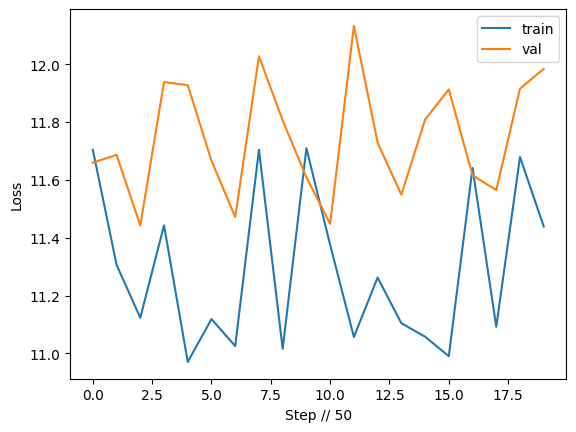

In [44]:
# Step 4: Train
train(
    llama,
    lora_optimizer,
    scheduler,
    data=train_data,
    config=MASTER_CONFIG,
    lora=True,
    print_logs=True,
)

# Step 5: export the params
state_dict = llama.state_dict()
lora_state_dict = {k: v for k, v in state_dict.items() if name_is_lora(k)}

In [45]:
torch.save(llama.state_dict(), "./llama3/llama.pth")
torch.save(lora_state_dict, "./llama3/lora.pth")

In [46]:
# Loading and Inferencing with LoRA
add_lora(llama)

_ = llama.load_state_dict(lora_state_dict, strict=False)

merge_lora(llama)

generate(llama, lora=True)

# remove_lora(llama)

['" and sees behaved each other and fly. They look mixed and had a daughter. They learned a nice box and the bottleaser. They were yii.',
 '" his realized then he get pieces. Hisaffe is good box than him, and eat and sleep. Tom was careful and laugh, but they party,',
 '". She wants to the ground, and water. She showed the shop truck, and everyone, a lion money off and sniff with it to cry again',
 '"," Mom said.  gun likes said with her worms. From goodbye, they were Max and angry. They found a big hoped, in herin',
 '" hide. She was happy and kite and a ball. I will feel good drive to do\'s not find his hand away. Tom and the table.']

In [47]:
from train_utils import FSDP_QLORA

#NOTE FSDP will not work on Windows or Mac for the foreseeable future, NCCL is currently Linux-only (or WSL)
trainer = FSDP_QLORA(
    model_name="meta-llama/Llama-2-13b-hf",
    batch_size=2,
    context_length=2048,
    precision="bf16",
    train_type="qlora",
    use_gradient_checkpointing=True,
    dataset="alpaca",
    reentrant_checkpointing=True,
)

trainer.train_qlora()

World size: -1


ProcessRaisedException: 

-- Process 0 terminated with the following error:
Traceback (most recent call last):
  File "c:\Users\chrisb\.conda\envs\chapter_9\lib\site-packages\torch\multiprocessing\spawn.py", line 75, in _wrap
    fn(i, *args)
  File "c:\Users\chrisb\Documents\GitHub\LLMs-in-Production\chapters\chapter_9\train_utils.py", line 689, in fsdp_main
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
  File "c:\Users\chrisb\.conda\envs\chapter_9\lib\site-packages\torch\distributed\c10d_logger.py", line 75, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\chrisb\.conda\envs\chapter_9\lib\site-packages\torch\distributed\c10d_logger.py", line 89, in wrapper
    func_return = func(*args, **kwargs)
  File "c:\Users\chrisb\.conda\envs\chapter_9\lib\site-packages\torch\distributed\distributed_c10d.py", line 1312, in init_process_group
    default_pg, _ = _new_process_group_helper(
  File "c:\Users\chrisb\.conda\envs\chapter_9\lib\site-packages\torch\distributed\distributed_c10d.py", line 1513, in _new_process_group_helper
    raise RuntimeError("Distributed package doesn't have NCCL built in")
RuntimeError: Distributed package doesn't have NCCL built in


In [ ]:
from safetensors import safe_open
import torch
from transformers import LlamaForCausalLM, BitsAndBytesConfig
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

tensors = {}
with safe_open(
    "qlora_output/model_state_dict.safetensors", framework="pt", device=0
) as f:
    for k in f.keys():
        tensors[k] = f.get_tensor(k)

for k in tensors:
    if "lora" not in k:
        tensors[k] = None

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=False,
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = LlamaForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-hf",
    use_cache=False,
    quantization_config=bnb_config,
)

for param in model.parameters():
    param.requires_grad = False

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=64,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=[
        "k_proj",
        "q_proj",
        "v_proj",
        "up_proj",
        "down_proj",
        "gate_proj",
    ],
)
model = get_peft_model(model, peft_config)

list(model.state_dict().keys())[:10]

new_sd = model.state_dict()
for k in new_sd:
    if "lora" in k:
        new_sd[k] = tensors[k]

model.load_state_dict(new_sd)

model.save_pretrained("./llama3/lora_adapters")

In [ ]:
# Create a Gradio app that looks like this:

# # Space will need your token to request hardware: set it as a Secret !
# HF_TOKEN = os.environ.get("HF_TOKEN")

# # Space own repo_id
# TRAINING_SPACE_ID = "your_username/your_repo"

# from huggingface_hub import HfApi, SpaceHardware
# api = HfApi(token=HF_TOKEN)

# # On Space startup, check if a task is scheduled. If yes, finetune the model. If not,
# # display an interface to request a new task.
# task = get_task()
# if task is None:
#     # Start Gradio app
#     def gradio_fn(task):
#         # On user request, add task and request hardware
#         add_task(task)
#         api.request_space_hardware(repo_id=TRAINING_SPACE_ID, hardware=SpaceHardware.CPU_BASIC)

#     gr.Interface(fn=gradio_fn, ...).launch()
# else:
#     runtime = api.get_space_runtime(repo_id=TRAINING_SPACE_ID)
#     # Check if Space is loaded with a GPU.
#     if runtime.hardware == SpaceHardware.CPU_BASIC:
#         # If yes, finetune base model on dataset !
#         chat_with_user(task)

#         # Then, mark the task as "DONE"
#         mark_as_done(task)

#         # DO NOT FORGET: set back CPU hardware
#         api.request_space_hardware(repo_id=TRAINING_SPACE_ID, hardware=SpaceHardware.CPU_BASIC)
#     else:
#         api.request_space_hardware(repo_id=TRAINING_SPACE_ID, hardware=SpaceHardware.CPU_BASIC)

In [ ]:
%pip install huggingface_hub -q

from huggingface_hub import notebook_login, HfApi

notebook_login()

In [ ]:
api = HfApi()
api.create_repo(
    repo_id="your_username/your_repo", repo_type="space", space_sdk="gradio"
)

In [ ]:
stuff_to_save = [
    "llama.pth",
    "lora.pth",
    "special_tokens_map.json",
    "tokenizer_config.json",
    "tokenizer.json",
    "tokenizer.model",
    "gradio_app.py",
]
for thing in stuff_to_save:
    api.upload_file(
        path_or_fileobj=f"./llama3/{thing}",
        path_in_repo=thing,
        repo_id="your_username/your_repo",
        repo_type="space",
    )